# Training Cyrillic letter CNN with Pytorch

## Load and Visualize data

In [1]:
import pandas as pd
dftrain = pd.read_csv("cyrillic_data/train.csv")

In [2]:
dftest = pd.read_csv("cyrillic_data/test.csv")

In [3]:
dfval = pd.read_csv("cyrillic_data/validation.csv")

In [4]:
len(dfval)

12123

In [5]:
dftrain = dftrain.append(dfval)

/tmp/ipykernel_39041/2243291462.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dftrain = dftrain.append(dfval)


Here I visualize one example at random for the letter Я, Russian == 32

In [6]:
dfcut = dftrain.query(f'Russian > -1 and Russian == 32')

In [7]:
labels = ['А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ё', 'Ж', 'З', 'И', 'Й',
          'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф',
          'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я']

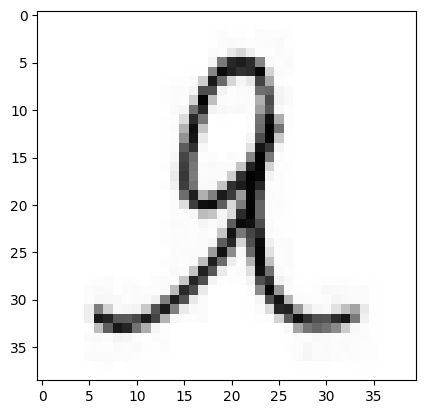

In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
files = dfcut['filename'].values
file = random.choice(files)

img = mpimg.imread(f'cyrillic_data/allrgb/{file}')

plt.imshow(img)

### Load Data

the code below loads the images with PIL and creates X and y labels.

Images are reshaped to be 64 x 64

In [11]:
capitalized = True

In [12]:
import numpy as np
#import cv2
import matplotlib.image as mpimg
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

df= dftrain.append(dfval)

if capitalized:
    dfrussian = df.query('Russian > -1 and letters81 > 41')
else:
    dfrussian = df.query('Russian > -1 and letters81 <= 41')
    
X = np.zeros((len(dfrussian), 64,64))
y = np.zeros((len(dfrussian),1))
dfrussian = dfrussian.reset_index()
for index, row in dfrussian.iterrows():
    img = Image.open(f'cyrillic_data/allgr/{row["filename"]}')
    #img.save()
    img = img.resize((64,64))
    #print(img.shape)
    #plt.imshow(img)
    plt.show()
    X[index] = np.array(img)/255.
    y[index]  = row['Russian']
    

/tmp/ipykernel_39041/1613260272.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df= dftrain.append(dfval)


### Visualize data many examples

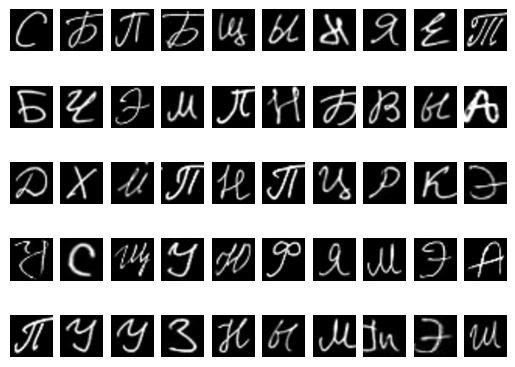

In [13]:
import matplotlib.pyplot as plt

figure = plt.figure()
n_images = 50

for index in range(1, n_images + 1):
    plt.subplot(5, 10, index)
    plt.axis('off')
    plt.imshow(X[index]*255., cmap='gray_r')

### Do train, val data splits and create pytorch data loaders

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
     np.expand_dims(X,1), y.flatten(), test_size=0.05, random_state=42)

In [36]:
train_data = TensorDataset( torch.tensor(X_train,dtype=torch.float), torch.tensor(y_train,dtype=torch.int64) ) 

In [37]:
val_data = TensorDataset(torch.tensor(X_val,dtype=torch.float), torch.tensor(y_val,dtype=torch.int64))

In [38]:
Ntrain = len(train_data)

In [39]:
Nval = len(val_data)

In [40]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True,pin_memory=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, pin_memory=True)

### Visualize batch of data from data loaders

(3, 266, 530)


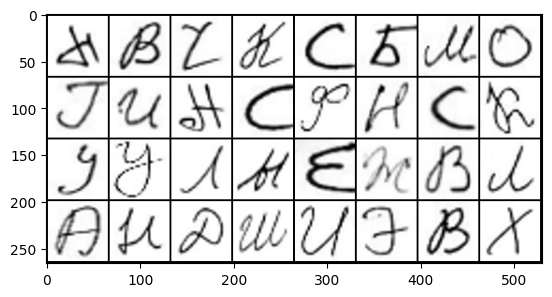

14224111811315391418211418112020122857212014425930222


In [41]:
import torchvision

import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img   
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(''.join('%1s' % labels[j].numpy() for j in range(32)))

## Build Model

Below a CNN is implemented in pytorch using 2 blocks each with 2 Conv2d + BatchNorm2d layers and a final MaxPool2d layer. Finally there are two feedforward layer and a softmax activation.

In [42]:
if torch.cuda.is_available():
  device = 'cuda' 
else:
  device = 'cpu' 

In [43]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.conv4_bn = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 13 * 13, 128)
        self.fc2 = nn.Linear(128, 33) 
        self.dropOut = nn.Dropout(0.2)

    def forward(self, x): 
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = self.dropOut(x)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = self.dropOut(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.dropOut(x)
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = self.dropOut(x)
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = self.dropOut(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64 * 13 * 13) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = Net()
model.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10816, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=33, bias=True)
  (dropOut): Dropout(p=0.2, inplace=False)
)

In [44]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
Net                                      --
├─Conv2d: 1-1                            320
├─BatchNorm2d: 1-2                       64
├─Conv2d: 1-3                            9,248
├─BatchNorm2d: 1-4                       64
├─Conv2d: 1-5                            18,496
├─BatchNorm2d: 1-6                       128
├─Conv2d: 1-7                            36,928
├─BatchNorm2d: 1-8                       128
├─MaxPool2d: 1-9                         --
├─Linear: 1-10                           1,384,576
├─Linear: 1-11                           4,257
├─Dropout: 1-12                          --
Total params: 1,454,209
Trainable params: 1,454,209
Non-trainable params: 0

## Training the model

In [45]:
if torch.cuda.is_available():
  device = 'cuda' 
else:
  device = 'cpu' 

In [46]:
model = model.cuda()

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [48]:
epochs = 9
    
epoch_log = []
loss_log = []
val_loss_log = []
accuracy_log = []
val_accuracy_log = []
for epoch in range(epochs):  
    print(f'Epoch: {epoch+1}')

    running_loss = 0.0
    running_correct = 0.0 
    running_total = 0.0
    actual_loss = 0.0
    # loop over training batches
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # clear gradients
        optimizer.zero_grad()

        # forward propagation
        outputs = model(inputs)

        # compute loss
        loss =  criterion(outputs, labels)

        # backward propagation
        loss.backward()
        optimizer.step()

        # add batch loss to running loss
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim = 1)

        running_total += labels.size(0)

        running_correct += (predicted == labels).sum().item()

        if i % 400 == 399:    
            valcorrect = 0 
            valtotal = 0 
            running_val_loss = 0

            with torch.no_grad():
                for data in val_loader:

                    # apply model to validation batch
                    images, labels = data

                    images = images.to(device)
                    labels = labels.to(device)

                    outputs = model(images)

                    val_loss =  criterion(outputs, labels)

                    _, predicted = torch.max(outputs.data, dim = 1)

                    valtotal += labels.size(0)

                    valcorrect += (predicted == labels).sum().item()
                    
                    running_val_loss += val_loss.item() 

                val_accuracy = 100 * valcorrect / valtotal
                accuracy = 100 * running_correct / running_total
                epoch_num = epoch + 1
                
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)} Train Accuracy = {accuracy:.3f}%')
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)} Val Accuracy = {val_accuracy:.3f}%')
                

    actual_loss = running_loss / running_total
    actual_val_loss = running_val_loss / valtotal
    epoch_log.append(epoch_num)
    loss_log.append(actual_loss)
    val_loss_log.append(actual_val_loss)
    accuracy_log.append(accuracy)
    val_accuracy_log.append(val_accuracy)
    print('\n')
    print(f"Epoch {epoch_num} summary stats:")
    print(f'Train Loss: {actual_loss:.4f}, Train Accuracy = {accuracy:.3f}%')
    print(f'Val Loss: {actual_val_loss:.4f}, Val Accuracy = {val_accuracy:.3f}%')
    print('\n')
    print('\n')
        

Epoch: 1
Epoch: 1, Mini-Batches Completed: 400 Train Accuracy = 73.898%
Epoch: 1, Mini-Batches Completed: 400 Val Accuracy = 91.156%
Epoch: 1, Mini-Batches Completed: 800 Train Accuracy = 82.578%
Epoch: 1, Mini-Batches Completed: 800 Val Accuracy = 93.478%
Epoch: 1, Mini-Batches Completed: 1200 Train Accuracy = 86.294%
Epoch: 1, Mini-Batches Completed: 1200 Val Accuracy = 92.589%


Epoch 1 summary stats:
Train Loss: 0.0155, Train Accuracy = 86.294%
Val Loss: 0.0081, Val Accuracy = 92.589%




Epoch: 2
Epoch: 2, Mini-Batches Completed: 400 Train Accuracy = 94.891%
Epoch: 2, Mini-Batches Completed: 400 Val Accuracy = 95.306%
Epoch: 2, Mini-Batches Completed: 800 Train Accuracy = 95.176%
Epoch: 2, Mini-Batches Completed: 800 Val Accuracy = 95.405%
Epoch: 2, Mini-Batches Completed: 1200 Train Accuracy = 95.216%
Epoch: 2, Mini-Batches Completed: 1200 Val Accuracy = 96.097%


Epoch 2 summary stats:
Train Loss: 0.0049, Train Accuracy = 95.216%
Val Loss: 0.0041, Val Accuracy = 96.097%




Epoc

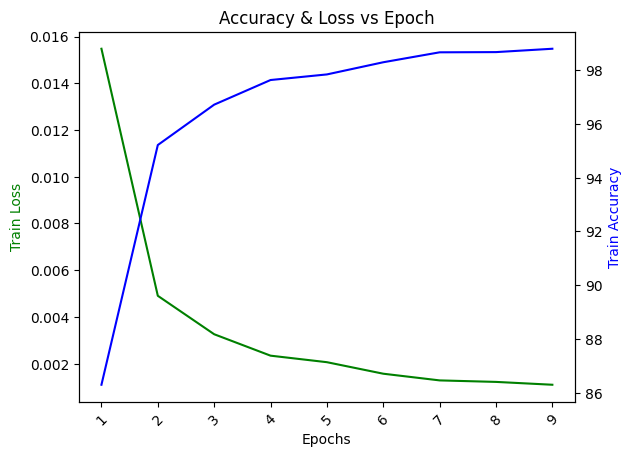

In [49]:
fig, ax1 = plt.subplots()

plt.title("Accuracy & Loss vs Epoch")
plt.xticks(rotation=45)

ax2 = ax1.twinx()

ax1.plot(epoch_log, loss_log, 'g-')

ax2.plot(epoch_log, accuracy_log, 'b-')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Train Loss', color='g')
ax2.set_ylabel('Train Accuracy', color='b')

plt.show()

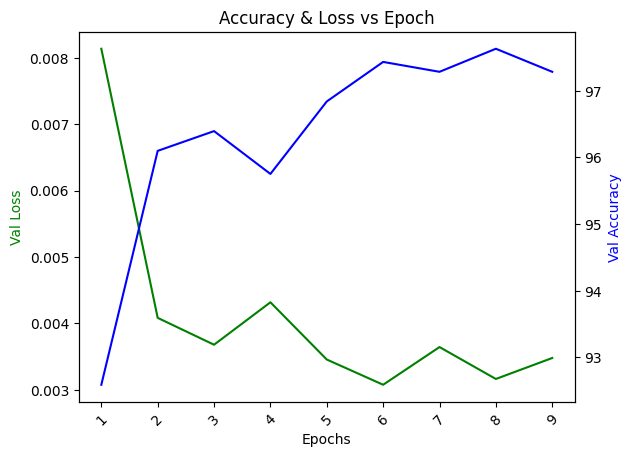

In [50]:
fig, ax1 = plt.subplots()

plt.title("Accuracy & Loss vs Epoch")
plt.xticks(rotation=45)

ax2 = ax1.twinx()

ax1.plot(epoch_log, val_loss_log, 'g-')


ax2.plot(epoch_log, val_accuracy_log, 'b-')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Val Loss', color='g')
ax2.set_ylabel('Val Accuracy', color='b')

plt.show()

In [121]:
# save the model

if capitalized:
    PATH = './CYRILLIC_pytorch.pth'
else:
    PATH = './cyrillic_pytorch.pth'    
torch.save(model.state_dict(), PATH)

## Inference and performance

In [123]:
val_iter = iter(val_loader)


images, newlabels = next(val_iter)


images = images.to(device)
newlabels = newlabels.to(device)

outputs = model(images)

# Get the class predictions using torch.max
_, predicted = torch.max(outputs, 1)

# Print our 128 predictions
print('Predicted: ', ''.join('%1s' % predicted[j].cpu().numpy() for j in range(32)))

Predicted:  14311179162452412047131630128163273228761232200102517


In [126]:
correct = 0 
total = 0

with torch.no_grad():
    for data in val_loader:
        images, labels = data
        # Move our data to GPU
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the val dataset: {accuracy:.3}%')

Accuracy of the network on the val dataset: 98.4%


###  Checking errors

In [32]:
def imgshow(title="", image = None, size = 6):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

Actual Label: 3, Predicted Label: 19


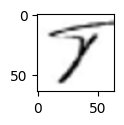

Actual Label: 16, Predicted Label: 19


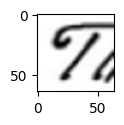

Actual Label: 28, Predicted Label: 25


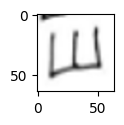

Actual Label: 6, Predicted Label: 5


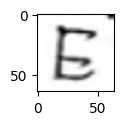

Actual Label: 8, Predicted Label: 20


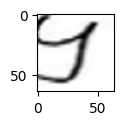

Actual Label: 10, Predicted Label: 9


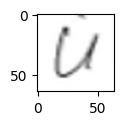

Actual Label: 28, Predicted Label: 11


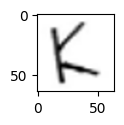

Actual Label: 18, Predicted Label: 5


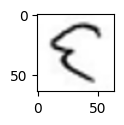

Actual Label: 28, Predicted Label: 26


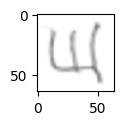

Actual Label: 9, Predicted Label: 10


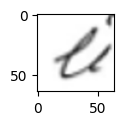

Actual Label: 2, Predicted Label: 17


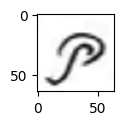

Actual Label: 9, Predicted Label: 12


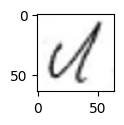

Actual Label: 3, Predicted Label: 19


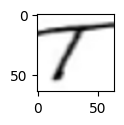

Actual Label: 28, Predicted Label: 21


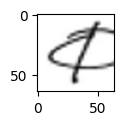

Actual Label: 13, Predicted Label: 14


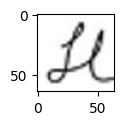

Actual Label: 22, Predicted Label: 4


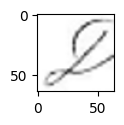

Actual Label: 18, Predicted Label: 12


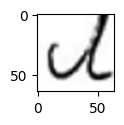

Actual Label: 17, Predicted Label: 21


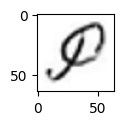

Actual Label: 3, Predicted Label: 19


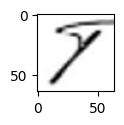

Actual Label: 20, Predicted Label: 22


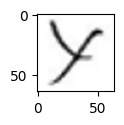

Actual Label: 7, Predicted Label: 0


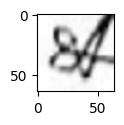

Actual Label: 26, Predicted Label: 25


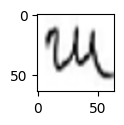

Actual Label: 22, Predicted Label: 7


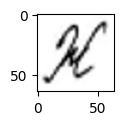

Actual Label: 23, Predicted Label: 26


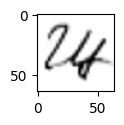

Actual Label: 0, Predicted Label: 14


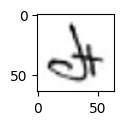

Actual Label: 24, Predicted Label: 7


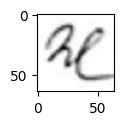

Actual Label: 17, Predicted Label: 21


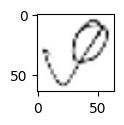

Actual Label: 0, Predicted Label: 14


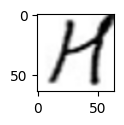

Actual Label: 28, Predicted Label: 25


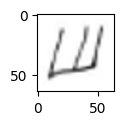

Actual Label: 6, Predicted Label: 2


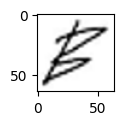

Actual Label: 20, Predicted Label: 9


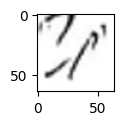

Actual Label: 9, Predicted Label: 10


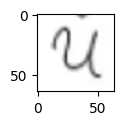

Actual Label: 18, Predicted Label: 5


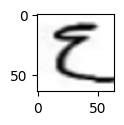

Actual Label: 12, Predicted Label: 13


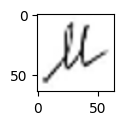

Actual Label: 9, Predicted Label: 31


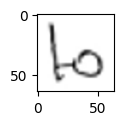

Actual Label: 5, Predicted Label: 6


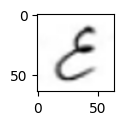

Actual Label: 10, Predicted Label: 9


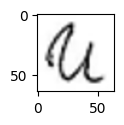

Actual Label: 15, Predicted Label: 4


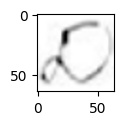

Actual Label: 5, Predicted Label: 6


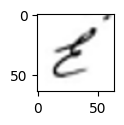

Actual Label: 6, Predicted Label: 5


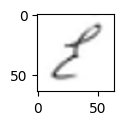

Actual Label: 9, Predicted Label: 10


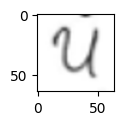

Actual Label: 5, Predicted Label: 6


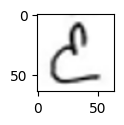

In [33]:
import cv2

model.eval()

allpreds=[]
alllabels=[]
with torch.no_grad():
    for data in val_loader:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)

        outputs =  model(images)

        predictions = torch.argmax(outputs, dim=1)
        allpreds.append(predictions.cpu().numpy())
        alllabels.append(labels.cpu().numpy())

        for i in range(data[0].shape[0]):
            pred = predictions[i].item()
            label = labels[i]
            if(label != pred):
                print(f'Actual Label: {pred}, Predicted Label: {label}')
                
                img = np.reshape(images[i].cpu().numpy(),[64,64])
                imgshow("", img, size = 1)

### Plot confusion matrix

In [137]:
y_pred = np.concatenate(allpreds)
y_true = np.concatenate(alllabels)

In [138]:
predictions

tensor([32,  6, 31, 26,  1, 28, 29, 31, 26, 14,  5, 30,  8, 13, 11, 11,  0, 15,
         3, 12,  8, 27, 12,  0, 10, 17,  7, 11, 27, 12], device='cuda:0')

In [139]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)


<AxesSubplot: >

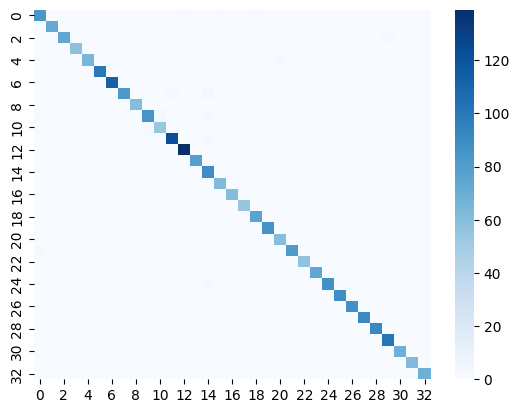

In [143]:
import seaborn as sns
sns.heatmap(cm, 
            fmt='.2%', cmap='Blues')

In [144]:
np.sum(y_true == y_pred)/len(y_true)

0.9795234549516009